# Transparency example

In [ ]:
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import torch
import yaml
from scipy.stats import norm
from torch.utils.data import DataLoader, Subset

from src.benchmark.consts import SCENE_DICT, SceneConfig
from src.config import ExperimentConfig
from src.data.dataset import HyperspectralScene
from src.models.modeller import Modeller

In [ ]:
plt.style.use(["science", "no-latex"])

In [3]:
class Prediction:
    def __init__(self, cfg: ExperimentConfig, scene: SceneConfig) -> None:
        self.cfg = cfg
        modeller = Modeller(scene.channels, self.cfg.k, 4)
        modeller.load_state_dict(torch.load(self.cfg.modeller_path))
        modeller.to(self.cfg.device)
        self.modeller = modeller

        self.dataset = HyperspectralScene(scene)

In [4]:
with open("configs/benchmark_phism.yaml") as file:
    config_data = yaml.safe_load(file)
    cfg = ExperimentConfig(**config_data)
experiment = Prediction(cfg=cfg, scene=SCENE_DICT["PU"])

In [5]:
dataset = experiment.dataset

In [ ]:
subset = Subset(dataset, [1, 2715, 19251])
classes = ["Asphalt", "Meadows", "Bare Soil"]

In [10]:
FEATURE_NAMES = [
    "mu",
    "sigma",
    "alpha",
    "scale",
]

In [11]:
feature_names = [
    rf"$\{param}_{i+1}$" if param != "scale" else rf"${param}_{i+1}$" for i in range(cfg.k) for param in FEATURE_NAMES
]

In [12]:
fulloader = DataLoader(subset, batch_size=1, shuffle=False)

In [13]:
def extract_features(modeller, dataloader):
    device = "cuda"
    features = []

    with torch.no_grad():
        for img in dataloader:
            img = img.to(device)
            ft = modeller(img)
            features.append(ft.cpu().numpy()[0, ..., 0, 0])

    return features

In [14]:
hats = extract_features(experiment.modeller, fulloader)

In [15]:
hats = [arr[np.argsort(arr[:, 0])] for arr in hats]

In [ ]:
def plot_partial_hats_skew(ax, pixel_hats: np.ndarray, class_name: str, channels: int, wavelengths: np.ndarray) -> None:
    """
    Plot skewed normal distributions and their sum on the given Axes.
    """
    hat_sum = np.zeros(channels)  # Sum of all distributions
    x_vals = np.linspace(0, channels, num=channels)

    cmap = cmc.batlowS  # batlowS colormap
    colors = [cmap(i) for i in range(len(pixel_hats))]

    for i, (stats, color) in enumerate(zip(pixel_hats, colors)):
        mu = channels * stats[0]
        sigma = channels * stats[1]
        scale = channels * stats[2]
        skew = channels * stats[3]

        pdf = 2 * scale * norm.pdf(x_vals, mu, sigma) * norm.cdf(skew * (x_vals - mu) / sigma)
        hat_sum += pdf

        ax.plot(
            wavelengths,
            pdf,
            color=color,
            label=rf"$\mu_{{{i+1}}}={wavelengths[int(mu)]:.1f},\ \sigma_{{{i+1}}}={sigma:.1f},\ \alpha_{{{i+1}}}={skew:.1f},\ \mathrm{{scale}}_{{{i+1}}}={scale:.1f}$",
        )

    # Plot sum in a distinct color (e.g. red, bold)
    ax.plot(wavelengths, hat_sum, color="black", linewidth=2, label="Sum of curves")

    ax.set_title(class_name)
    ax.set_xlabel("Wavelength [nm]")
    ax.set_ylabel("Intensity")
    ax.legend(fontsize=8)


def plot_three_classes(pixel_hats_list, class_names, channels, wavelengths):
    """
    Plot three class distributions side by side.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, pixel_hats, class_name in zip(axes, pixel_hats_list, class_names):
        plot_partial_hats_skew(ax, pixel_hats, class_name, channels, wavelengths)

    plt.tight_layout()
    plt.show()


In [20]:
wv = np.linspace(430, 860, num=SCENE_DICT["PU"].channels)

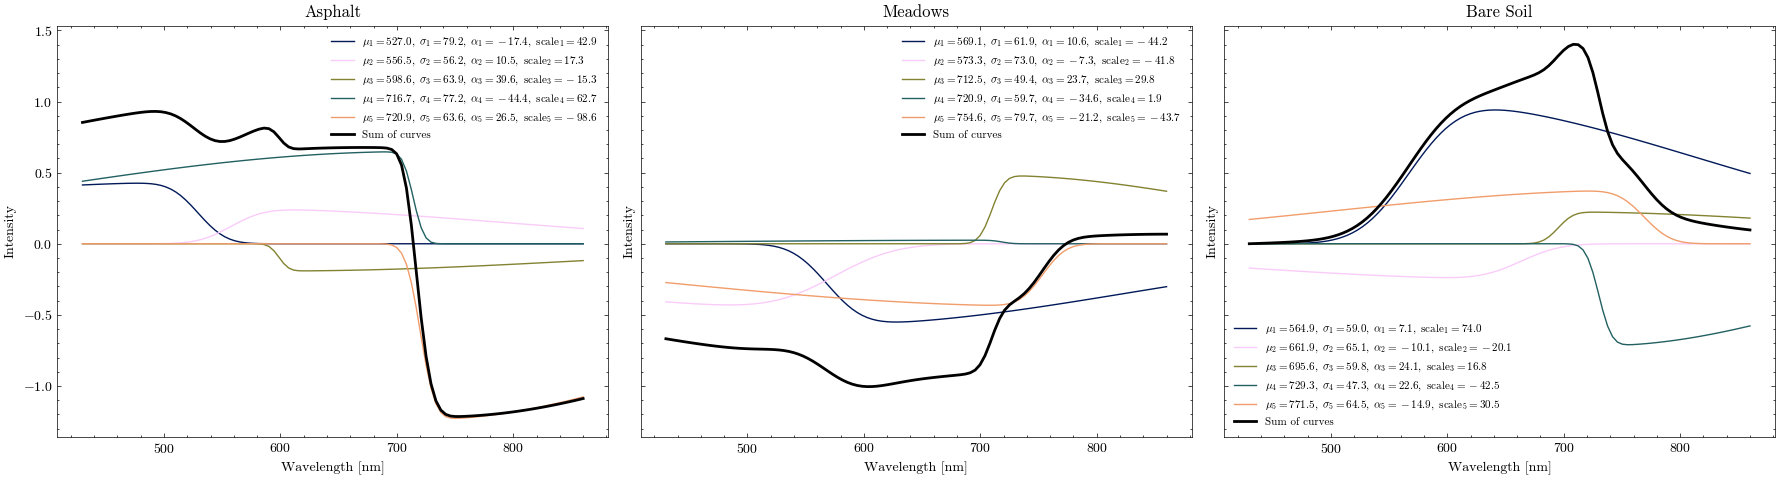

In [21]:
plot_three_classes(hats, classes, channels=SCENE_DICT["PU"].channels, wavelengths=wv)

## Prediction viz

In [ ]:
def plot_partial_hats_skew_gt(ax, pixel_hats: np.ndarray, class_name: str,
                              gt_refl: np.ndarray, div: np.ndarray,
                              bias: np.ndarray, channels: int,
                              wavelengths: np.ndarray) -> None:
    """
    Plot skewed normal distributions and their sum on the given Axes.
    """
    hat_sum = np.zeros(channels)
    x_vals = np.linspace(0, channels, num=channels)

    cmap = cmc.batlowS
    colors = [cmap(i) for i in range(len(pixel_hats)+2)]

    for i, (stats, color) in enumerate(zip(pixel_hats, colors)):
        mu = channels * stats[0]
        sigma = channels * stats[1]
        scale = channels * stats[2]
        skew = channels * stats[3]

        pdf = 2 * scale * norm.pdf(x_vals, mu, sigma) * norm.cdf(skew * (x_vals - mu) / sigma)
        hat_sum += pdf * div

        ax.plot(
            wavelengths,
            pdf * div + bias,
            color=color,
            linewidth=2,
            # label=rf"$\mathrm{{S}}_{{{i+1}}}({wavelengths[int(mu)]:.1f}, {sigma:.1f}, {skew:.1f}, {scale:.1f})$",
            label=rf"$\mathrm{{S}}_{{{i+1}}}(\mathdefault{{{wavelengths[int(mu)]:.1f}}}, \mathdefault{{{sigma:.1f}}}, \mathdefault{{{skew:.1f}}}, \mathdefault{{{scale:.1f}}})$",
        )

    ax.plot(wavelengths, hat_sum + bias, color=colors[-2], linewidth=2.5, linestyle=":", label="S + mean estimate")
    ax.plot(wavelengths, bias, label="Mean estimate", linewidth=2.5, linestyle="--", c=colors[-1])

    ax.set_title(class_name)
    ax.set_xlabel("Wavelength [nm]")

    ax.legend(
        fontsize=18.5,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=1,
        frameon=False
    )


def plot_three_classes_gt(pixel_hats_list, class_names, gt_refl, div, bias, channels, wavelengths):
    """
    Plot three class distributions side by side with per-subplot legends below.
    """
    fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
    axes[0].set_ylabel("Reflectance")

    for ax, pixel_hats, class_name in zip(axes, pixel_hats_list, class_names):
        plot_partial_hats_skew_gt(ax, pixel_hats, class_name, gt_refl, div, bias, channels, wavelengths)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.03, hspace=0.3, bottom=0.25)  # extra space for legends
    plt.savefig("ieee_hats_gt.pdf", transparent=True)
    plt.show()

In [ ]:
plt.rcParams.update(
    {
        "figure.figsize": (3.3, 2.5),
        "figure.dpi": 600,
        "font.size": 21,
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        # "axes.unicode_minus": True,
        "font.family": ["serif"],
        "font.serif": "Times New Roman",
        # X axis
        "xtick.direction": "in",
        "xtick.major.size": 6,
        "xtick.major.width": 1.0,
        "xtick.minor.size": 3.0,
        "xtick.minor.width": 1.0,
        "xtick.minor.visible": True,
        "xtick.top": True,
        # Y axis
        "ytick.direction": "in",
        "ytick.major.size": 6,
        "ytick.major.width": 1.0,
        "ytick.minor.size": 3.0,
        "ytick.minor.width": 1.0,
        "ytick.minor.visible": True,
        "ytick.right": True,
    }
)

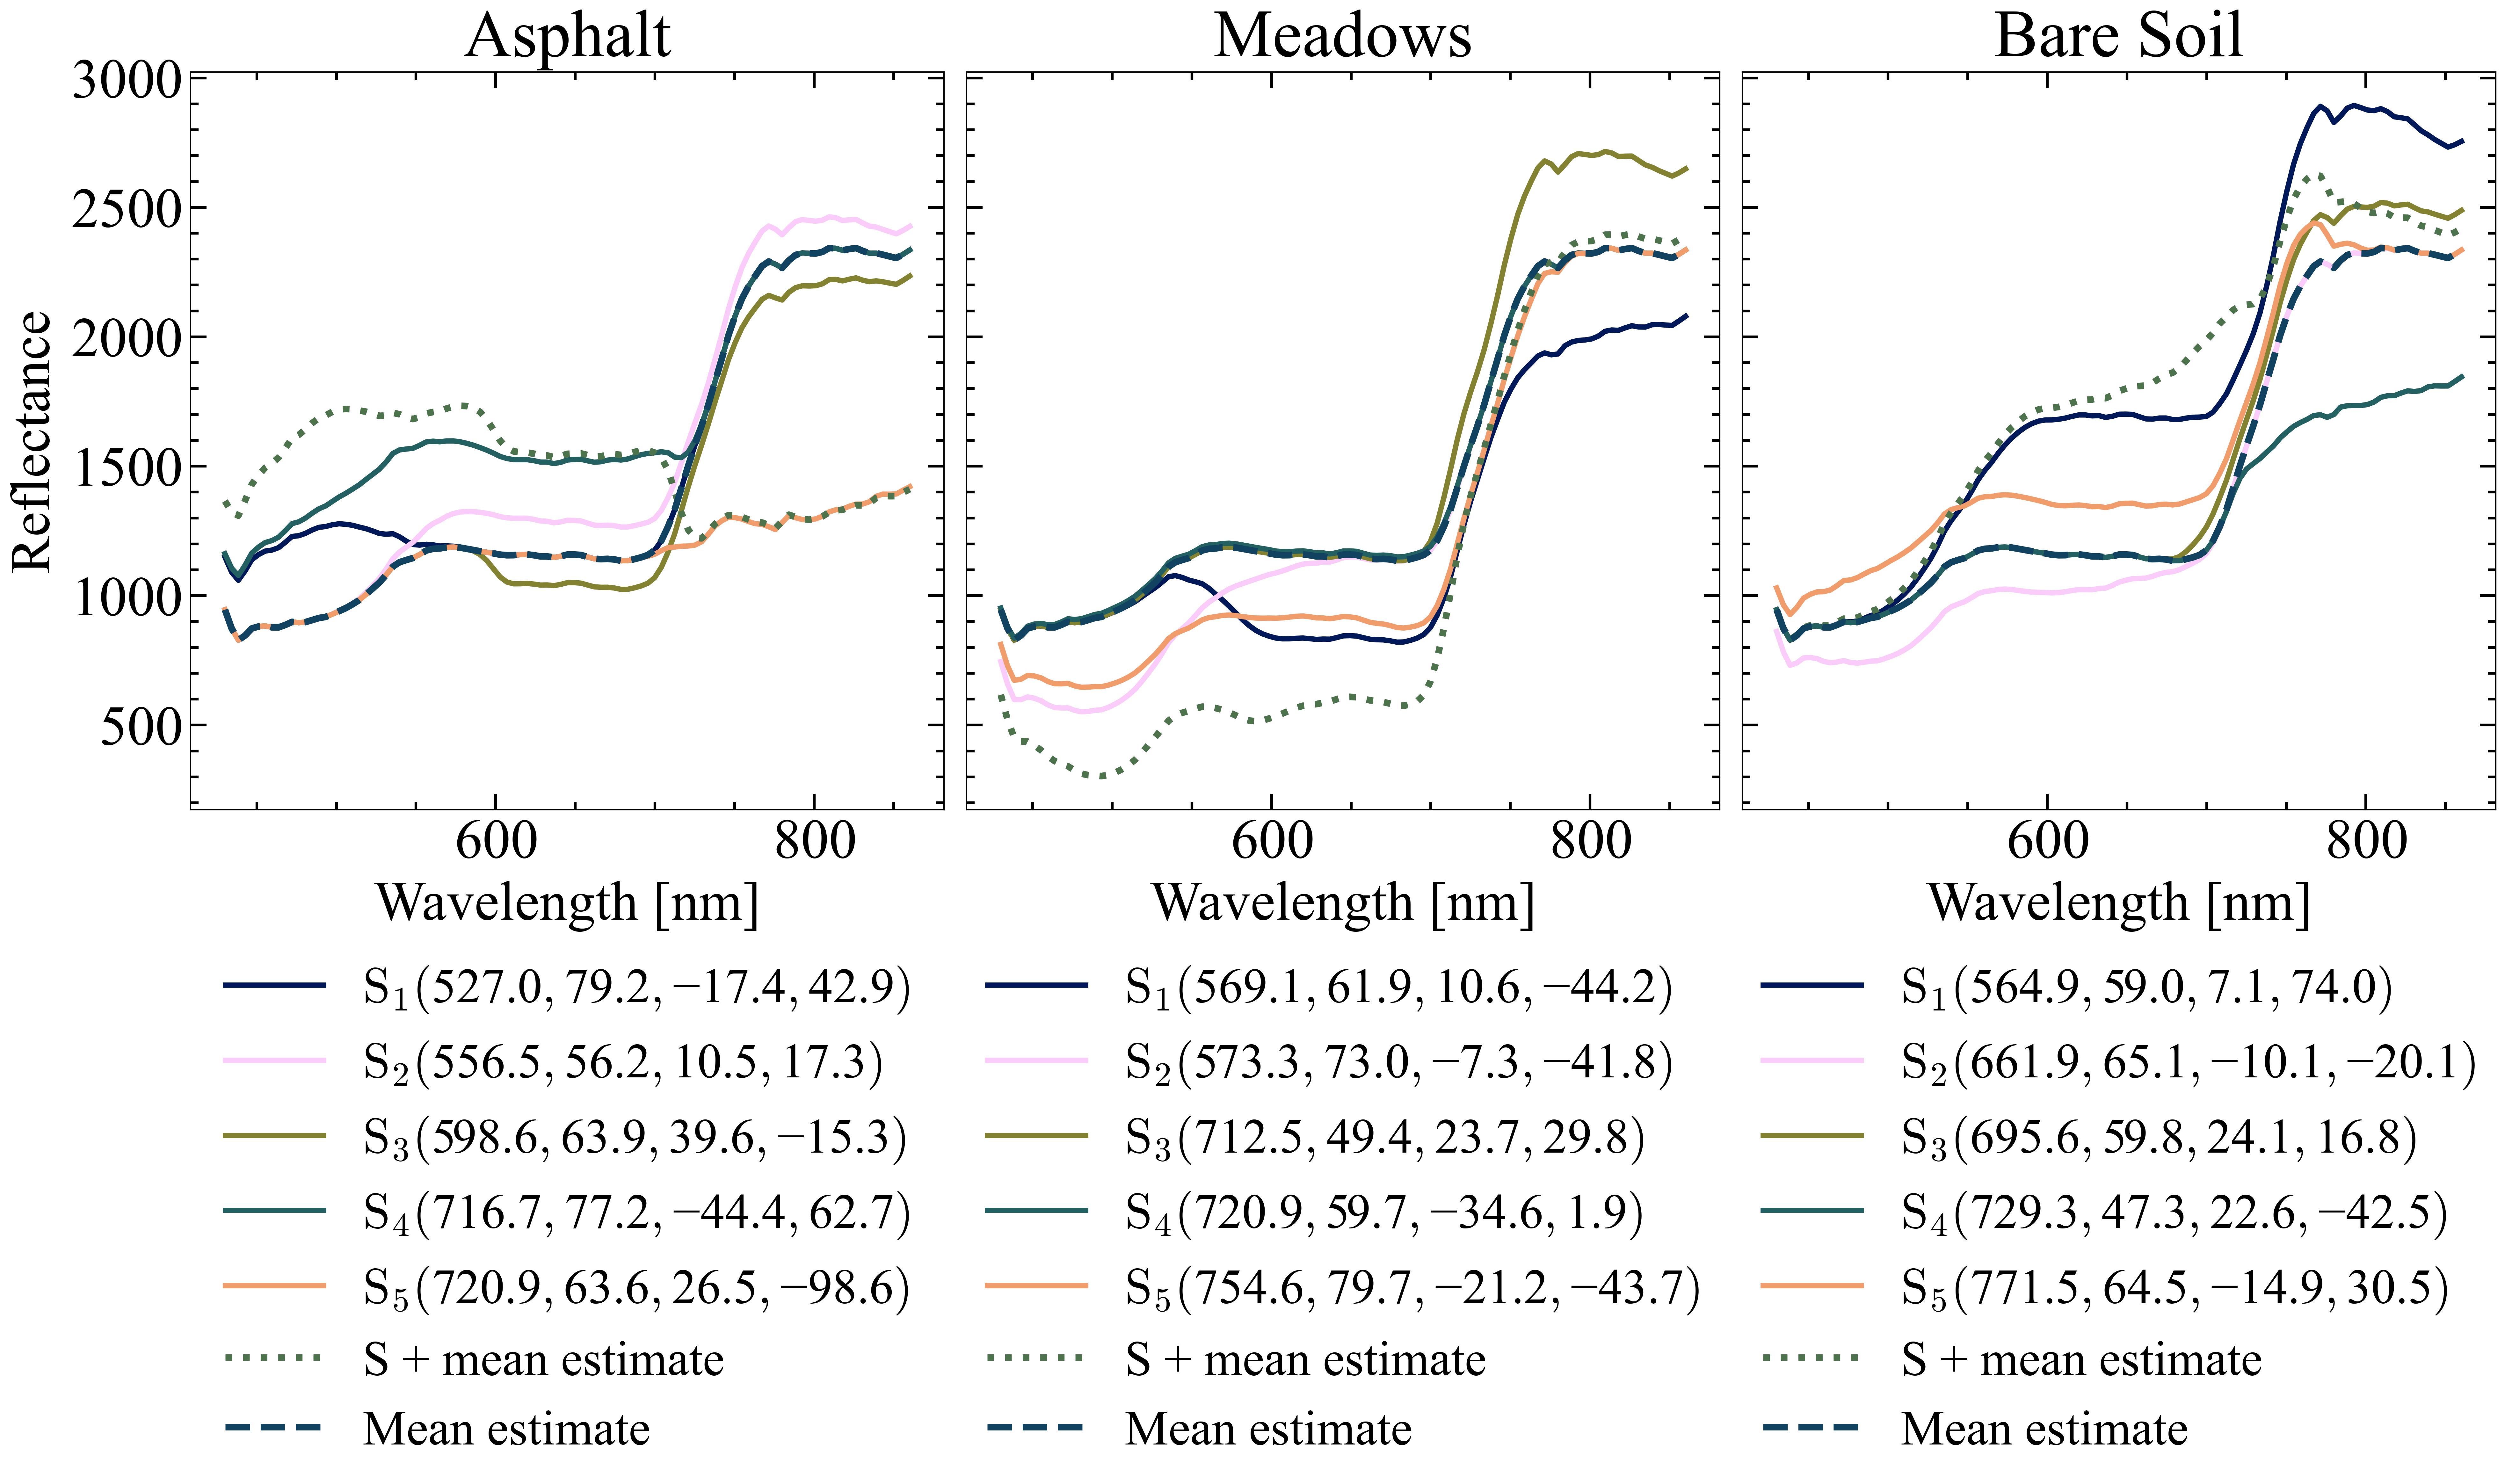

In [27]:
plot_three_classes_gt(
    hats, classes, 0, dataset.std.numpy(), dataset.mean.numpy(), channels=SCENE_DICT["PU"].channels, wavelengths=wv
)